In [17]:
%matplotlib inline
from seaborn import apionly as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

plt.style.use(['seaborn-whitegrid', 'seaborn-ticks'])
import matplotlib.ticker as plticker
rcParams['figure.figsize'] = 8, 6
rcParams['axes.facecolor'] = 'FFFFFF'
rcParams['savefig.facecolor'] = 'FFFFFF'
rcParams['figure.facecolor'] = 'FFFFFF'

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'

rcParams.update({'figure.autolayout': True})

%config InlineBackend.figure_format = 'retina'

import sklearn

import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

import uproot

import warnings

warnings.simplefilter('ignore')

In [3]:
!xrdcp root://eoslhcb.cern.ch//eos/lhcb/user/d/dohanlon/baseline_100_ToEPM_test.root tag.root
d = uproot.open("tag.root")['tree']

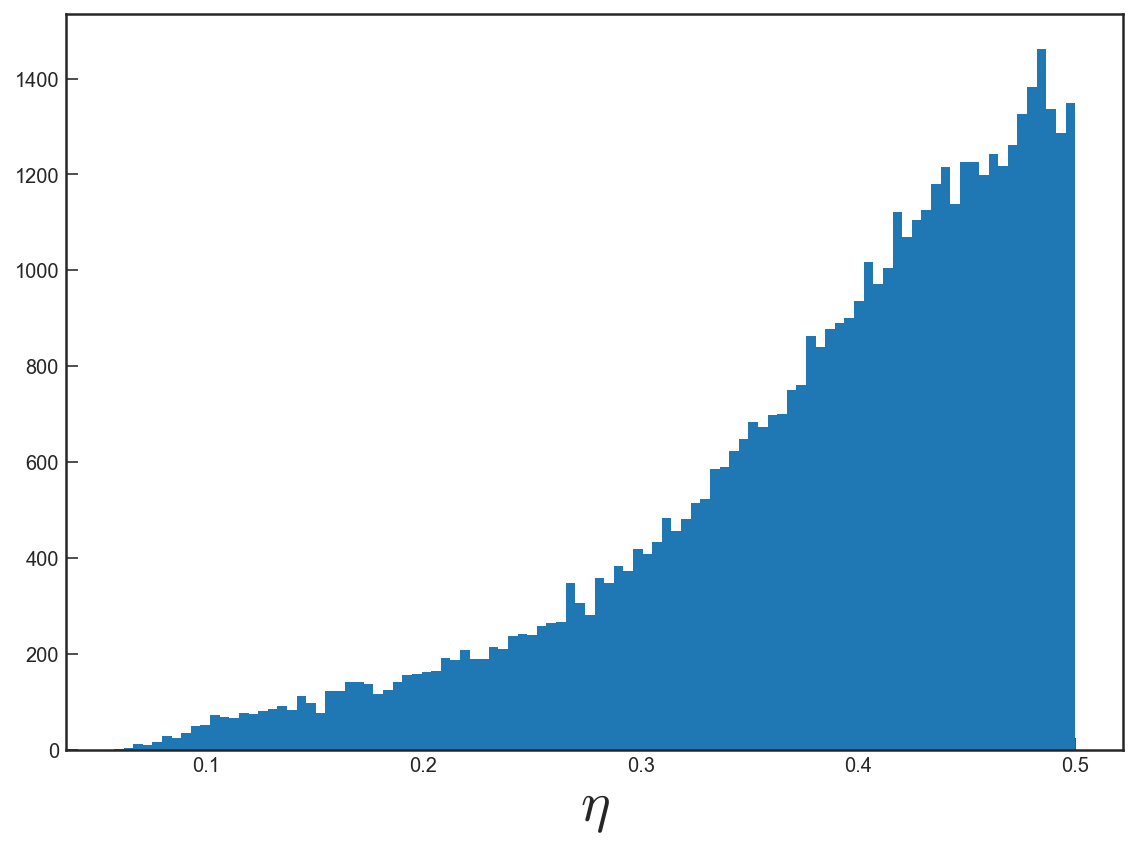

In [4]:
plt.hist(d.array('eta'), bins = 100);
plt.xlabel(r'$\eta$', fontsize = 28);

In [5]:
tagEta = d.array('eta')
tagTrue = d.array('B_ID')
tagTrue[tagTrue == -521] = 0
tagTrue[tagTrue == 521] = 1
tagPred = d.array('tag')
tagPred[tagPred == -1] = 0

tagEtaProb = tagEta
tagEtaProb[tagPred > 0] = (1 - tagEtaProb[tagPred > 0])

In [6]:
def calibrationFunction(a, b, c, eta):
    return a * eta**2 + b * eta + c

In [7]:
from tensorflow_probability import edward2 as ed

def logistic_model():

    rv_a = ed.Normal(loc = 0.0, scale = 1.0, name = 'rv_a')
    rv_b = ed.Normal(loc = 1.0, scale = 1.0, name = 'rv_b')
    rv_c = ed.Normal(loc = 0.0, scale = 1.0, name = 'rv_c')
    
    # Transform tag eta into true eta
    
    omega = calibrationFunction(rv_a, rv_b, rv_c, tagEtaProb)
    
    # Observe either correct (1) or incorrect (0) tag
    
    obs = ed.Bernoulli(probs = omega, name = 'obs')
    
    return obs

log_joint = ed.make_log_joint_fn(logistic_model)

def target_log_prob_fn(a, b, c):
    return log_joint(rv_a = a, rv_b = b, rv_c = c, obs = tagTrue)

In [9]:
with tf.variable_scope("params", reuse=tf.AUTO_REUSE):

    initial_chain_state = [
        0.1 * tf.ones([], dtype=tf.float32, name="init_rv_a"),
        0.1 * tf.ones([], dtype=tf.float32, name="init_rv_b"),
        0.1 * tf.ones([], dtype=tf.float32, name="init_rv_c"),
    ]

    num_results = 100000
    num_burnin_steps = 10000

    step_size = tf.get_variable(
      name='step_size',
      initializer=1.0,
      trainable=False)
    step_size_adaptation_step_counter = tf.get_variable(
      name='step_size_adaptation_step_counter',
      initializer=-1,
      dtype=tf.int32,
      trainable=False)

    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
            num_leapfrog_steps=10))

    a, b, c = states

    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        a_, b_, c_, is_accepted_,  = sess.run([ a, b, c, kernel_results.is_accepted])


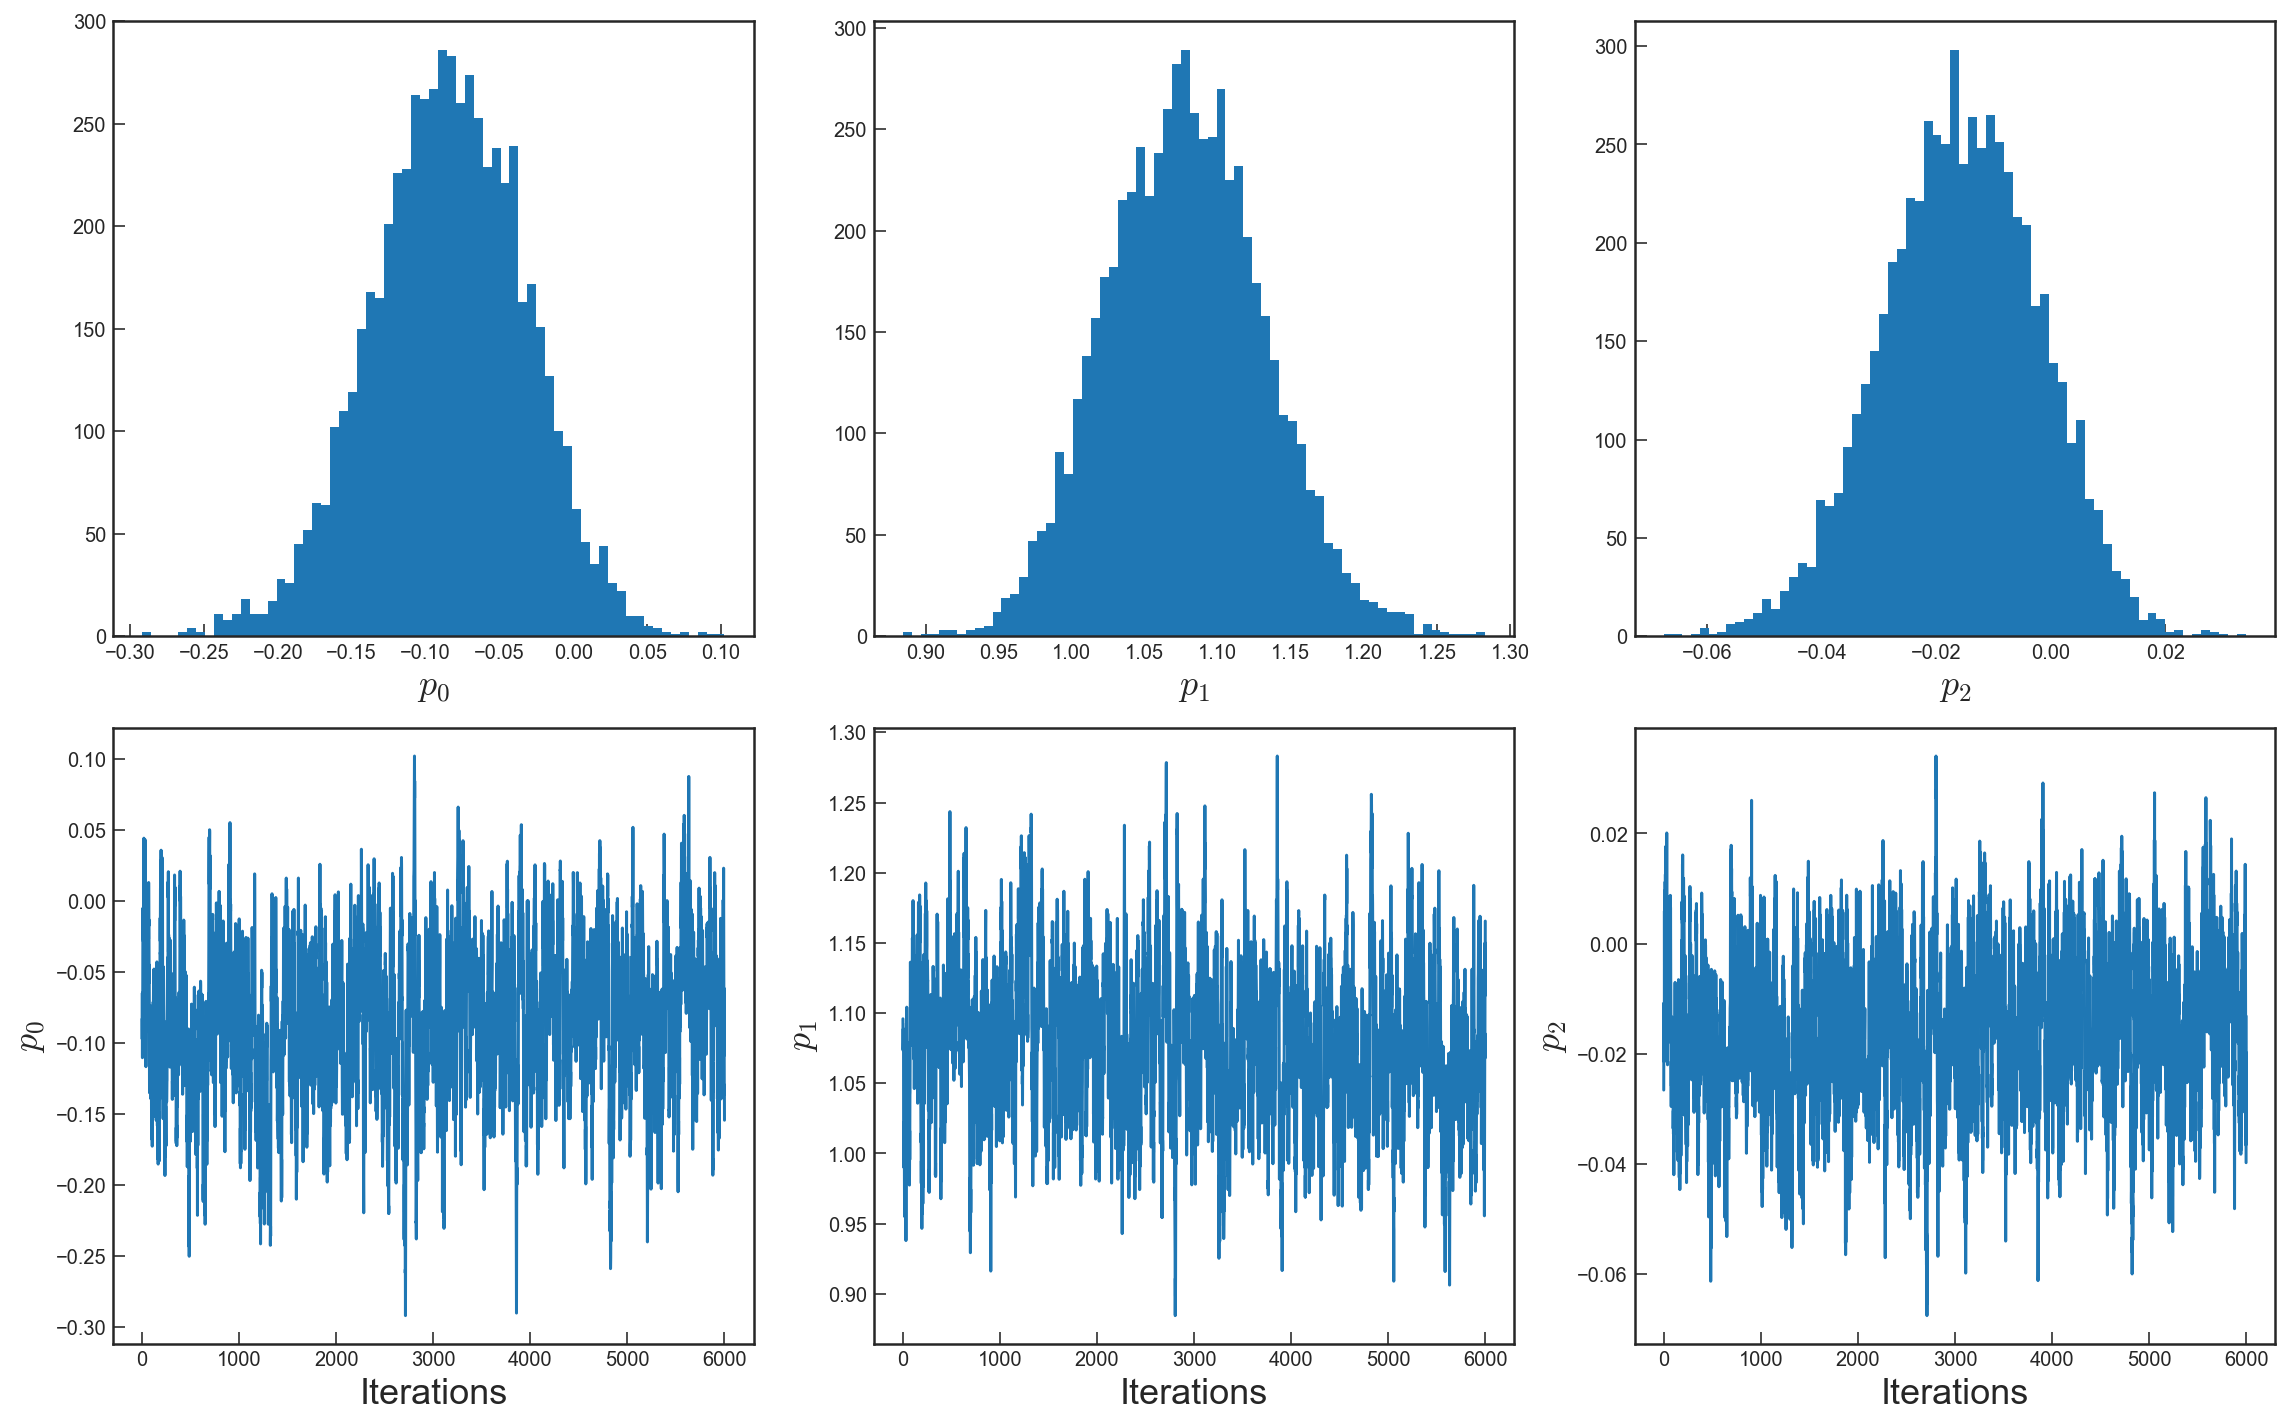

In [10]:
fig, ax = plt.subplots(2, 3, figsize = (16, 10))

ax[1][0].plot(a_[is_accepted_][100:]);
ax[1][0].set_xlabel('Iterations', fontsize = 18);
ax[1][0].set_ylabel(r'$p_0$', fontsize = 18);
ax[1][1].plot(b_[is_accepted_][100:]);
ax[1][1].set_xlabel('Iterations', fontsize = 18);
ax[1][1].set_ylabel(r'$p_1$', fontsize = 18);
ax[1][2].plot(c_[is_accepted_][100:]);
ax[1][2].set_xlabel('Iterations', fontsize = 18);
ax[1][2].set_ylabel(r'$p_2$', fontsize = 18);

ax[0][0].hist(a_[is_accepted_][100:], bins = 65);
ax[0][0].set_xlabel(r'$p_0$', fontsize = 18);
ax[0][1].hist(b_[is_accepted_][100:], bins = 65);
ax[0][1].set_xlabel(r'$p_1$', fontsize = 18);
ax[0][2].hist(c_[is_accepted_][100:], bins = 65);
ax[0][2].set_xlabel(r'$p_2$', fontsize = 18);

In [11]:
from scipy.stats import binned_statistic

In [18]:
bins = np.linspace(0, 0.5, 75)

aVal = np.mean(a_)
bVal = np.mean(b_)
cVal = np.mean(c_)

statNominal, _, _ = binned_statistic(tagEta, values = (tagPred != tagTrue).astype(np.int32), statistic = lambda x : np.sum(x) / float(len(x)), bins = bins)
statBS = []

# Let's do some bootstrapping
for i in tqdm(range(1000)):
    idxs = np.random.choice(range(len(tagEta)), size = len(tagEta), replace = True)
    stat, _, _ = binned_statistic(tagEta[idxs], values = (tagPred[idxs] != tagTrue[idxs]).astype(np.int32), statistic = lambda x : np.sum(x) / float(len(x)), bins = bins)
    statBS.append(stat)


100%|██████████| 1000/1000 [00:21<00:00, 45.63it/s]


In [19]:
statBSErrs = np.nanstd(statBS, axis = 0)

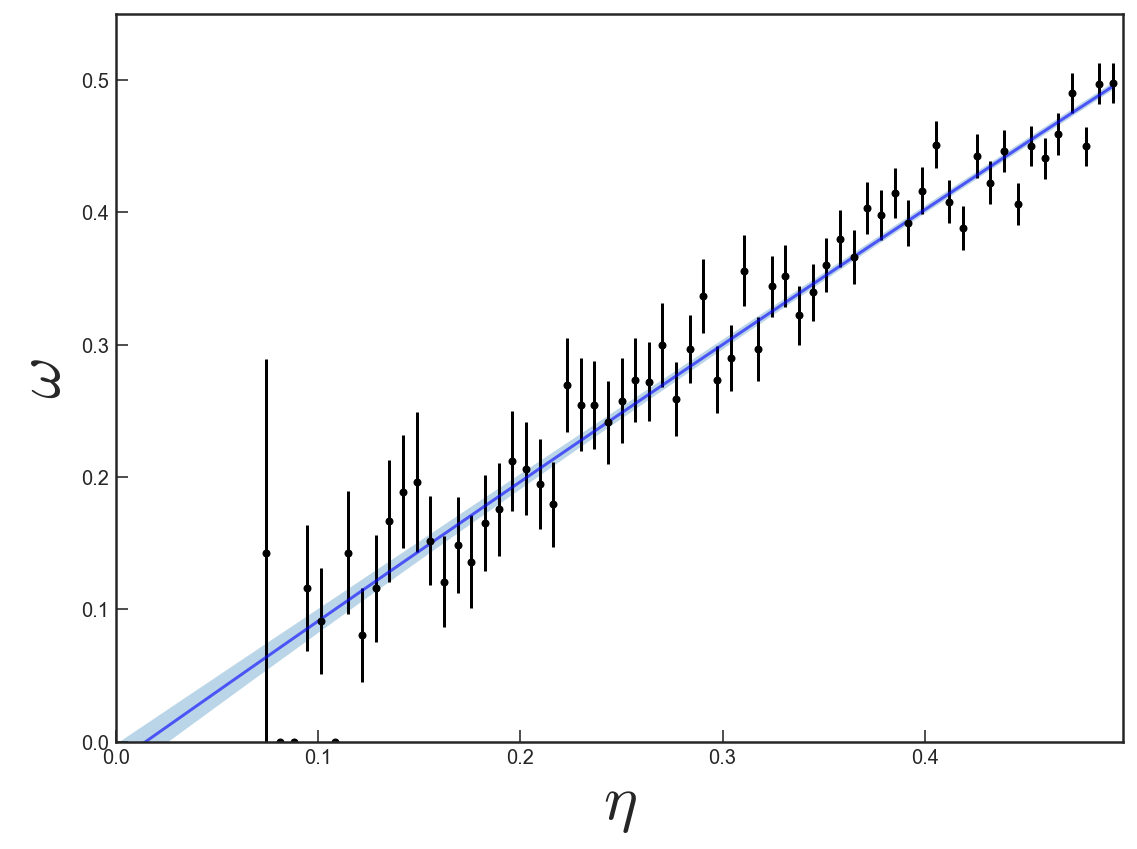

In [20]:
ySamples = calibrationFunction(a_[is_accepted_].reshape(1, -1),
                            b_[is_accepted_].reshape(1, -1),
                            c_[is_accepted_].reshape(1, -1),
                            bins[:-1].reshape(-1, 1))

yErrLow = np.percentile(ySamples, 16, axis = 1)
yErrHigh = np.percentile(ySamples, 84, axis = 1)

y = calibrationFunction(aVal, bVal, cVal, bins[:-1])

plt.errorbar(bins[:-1], statNominal, yerr = statBSErrs, fmt = '.', color = 'k')
plt.plot(bins[:-1], y, color = 'blue', alpha = 0.6)
plt.fill_between(bins[:-1], yErrLow, yErrHigh, alpha = 0.3)

plt.xlim(0, bins[-2] + 0.005)
plt.ylim(0, 0.55)
plt.ylabel(r'$\omega$', fontsize = 32);
plt.xlabel(r'$\eta$', fontsize = 32);


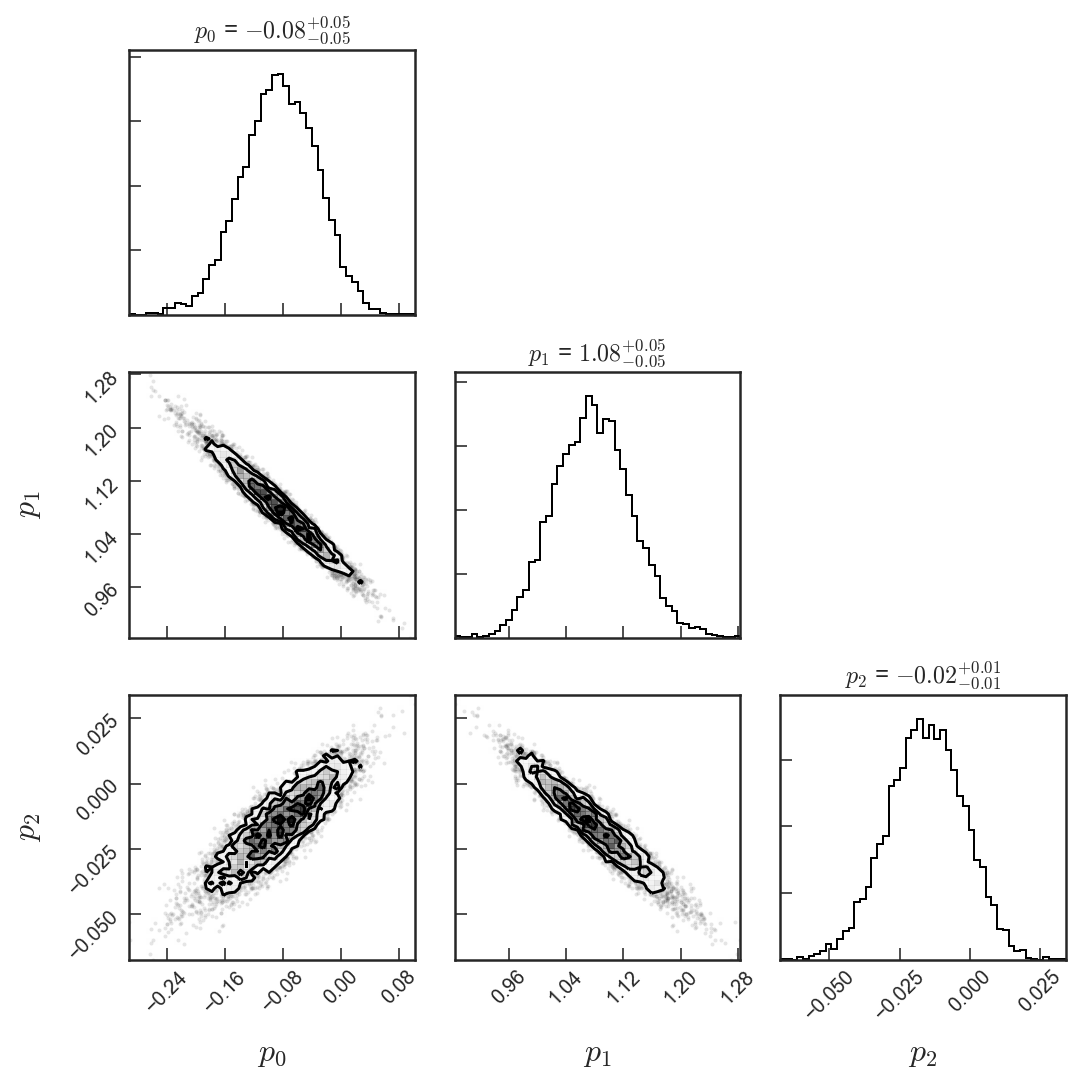

In [21]:
from corner import corner

data = np.vstack((a_[is_accepted_], b_[is_accepted_], c_[is_accepted_])).T

corner(data, labels = [r'$p_0$', r'$p_1$', r'$p_2$'], show_titles = True, label_kwargs=dict(fontsize=16), bins = 50);